---
# Real Example: t-SNE — Single-Cell Genomics


**Single-cell RNA sequencing (scRNA-seq)** measures gene expression (30,000+ genes) in individual cells, enabling discovery of cell types, developmental trajectories, and disease mechanisms. With millions of cells per experiment, exploratory visualization is essential but challenging due to the curse of dimensionality.

### Why t-SNE for Single-Cell Data?

t-SNE has become the **de facto standard** for single-cell visualization because:

1. **Dominance of local structure**: Cell-type identity is primarily governed by local gene expression patterns. t-SNE explicitly preserves neighborhood relationships, making it well suited to capturing biologically meaningful clusters.

2. **Visualization as a scientific tool**: In this context, visualization serves exploratory analysis rather than feature extraction. Consequently, stochasticity is acceptable, as researchers routinely inspect multiple runs to assess robustness.

3. **Extreme dimensionality**: Single-cell gene expression data often reside in spaces of up to 30,000 dimensions, where linear methods fundamentally break down. t-SNE's use of heavy-tailed distributions addresses the mismatch between high-dimensional and low-dimensional distance relationships.

4. **Empirical effectiveness of perplexity tuning**: Practical heuristics have emerged within the community (e.g., perplexity ≈ $\sqrt{n}$), which perform reliably across datasets with varying numbers of cell types.

### Standard scRNA-seq Preprocessing Pipeline

Based on best practices from Kobak and Berens (2019):

1. **Log-normalization** of UMI counts
2. **Highly-variable gene selection** (top 2000-5000 genes)
3. **PCA to 50 dimensions** as t-SNE input (critical for speed and noise reduction)
4. **t-SNE configuration**: Perplexity 30–50, PCA initialization (not random!)
5. **FIt-SNE or Barnes-Hut** implementation for speed

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time
import warnings

from sklearn.datasets import make_swiss_roll, load_digits, make_moons, make_circles
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plot settings
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("Libraries loaded successfully!")































Libraries loaded successfully!


In [3]:
# Simulating Single-Cell RNA-seq Data
# We simulate scRNA-seq data with distinct cell types to demonstrate t-SNE's effectiveness

from sklearn.datasets import make_blobs

# Simulate single-cell gene expression data
# - 3000 cells (typical small scRNA-seq experiment)
# - 2000 highly variable genes (after feature selection)
# - 8 distinct cell types (clusters)

n_cells = 3000
n_genes = 2000  # Highly variable genes after preprocessing
n_cell_types = 8

# Generate simulated gene expression data with cell type clusters
np.random.seed(RANDOM_STATE)

# Create cluster centers with varying separation (mimicking real scRNA-seq)
X_scrna, cell_types = make_blobs(
    n_samples=n_cells, 
    n_features=n_genes,
    centers=n_cell_types,
    cluster_std=[1.5, 2.0, 1.8, 2.2, 1.6, 2.1, 1.9, 1.7],  # Varying cluster tightness
    random_state=RANDOM_STATE
)

# Add biological noise (scRNA-seq is inherently noisy)
X_scrna += np.random.normal(0, 0.5, X_scrna.shape)

# Simulate log-normalization (common preprocessing step)
X_scrna = np.log1p(np.abs(X_scrna))  # log(1 + x) transformation

# Cell type labels
cell_type_names = ['T cells', 'B cells', 'Monocytes', 'NK cells', 
                   'Dendritic', 'Neutrophils', 'Macrophages', 'Stem cells']

print("SIMULATED SINGLE-CELL RNA-seq DATASET")
print("-"*60)
print(f"Number of cells: {n_cells}")
print(f"Number of genes (features): {n_genes}")
print(f"Number of cell types: {n_cell_types}")
print(f"Cell types: {cell_type_names}")
print(f"\nData shape: {X_scrna.shape}")
print(f"This mimics real scRNA-seq after preprocessing:")
print("  1. Raw counts → Log-normalization")
print("  2. 30,000 genes → 2,000 highly variable genes")

SIMULATED SINGLE-CELL RNA-seq DATASET
------------------------------------------------------------
Number of cells: 3000
Number of genes (features): 2000
Number of cell types: 8
Cell types: ['T cells', 'B cells', 'Monocytes', 'NK cells', 'Dendritic', 'Neutrophils', 'Macrophages', 'Stem cells']

Data shape: (3000, 2000)
This mimics real scRNA-seq after preprocessing:
  1. Raw counts → Log-normalization
  2. 30,000 genes → 2,000 highly variable genes


Step 1: PCA dimensionality reduction (2000 → 50 dimensions)
  Variance explained by 50 PCs: 62.73%

Step 2: t-SNE on PCA-reduced data


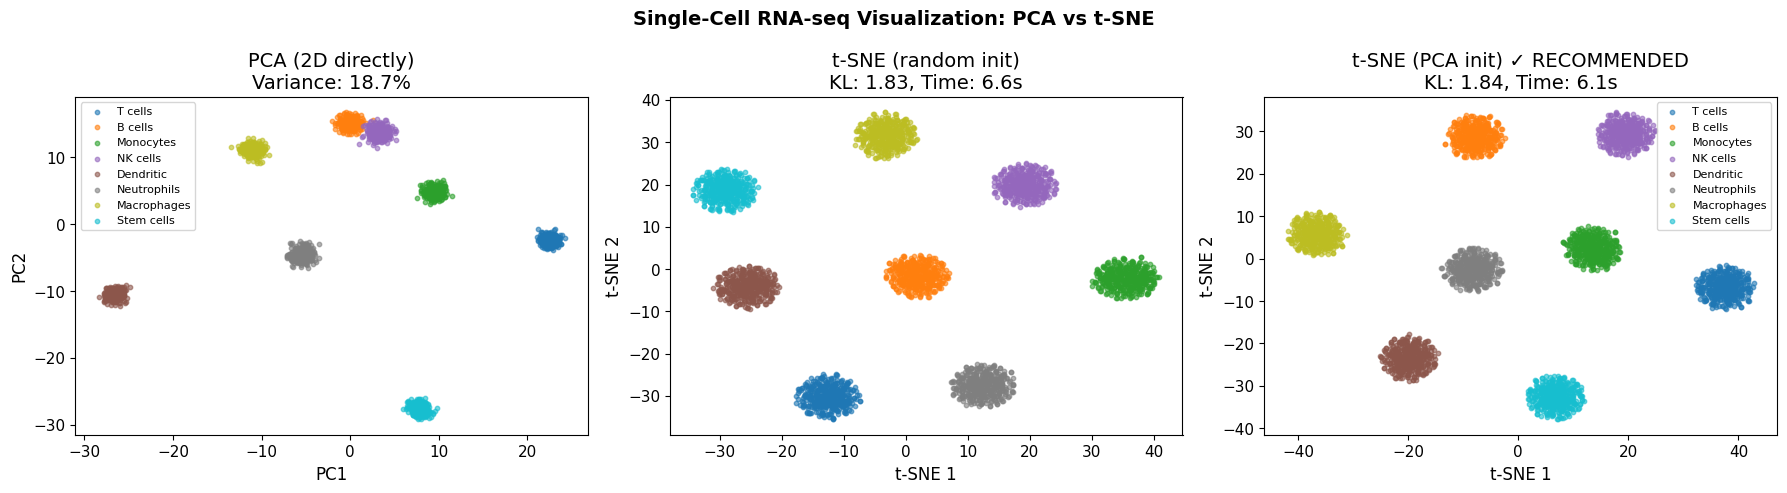

In [4]:
# 4 Standard scRNA-seq Pipeline: PCA → t-SNE

# Step 1: Standardize the data
scaler = StandardScaler()
X_scrna_scaled = scaler.fit_transform(X_scrna)

# Step 2: PCA to 50 dimensions (critical preprocessing step!)
# This reduces noise and speeds up t-SNE significantly
print("Step 1: PCA dimensionality reduction (2000 → 50 dimensions)")
pca_50 = PCA(n_components=50, random_state=RANDOM_STATE)
X_pca_50 = pca_50.fit_transform(X_scrna_scaled)
print(f"  Variance explained by 50 PCs: {pca_50.explained_variance_ratio_.sum():.2%}")

# Step 3: t-SNE on PCA-reduced data
print("\nStep 2: t-SNE on PCA-reduced data")

# Compare: PCA alone vs PCA + t-SNE
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Create a colormap for cell types
colors = plt.cm.tab10(np.linspace(0, 1, n_cell_types))

# Plot 1: PCA (first 2 components)
pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_2d = pca_2d.fit_transform(X_scrna_scaled)
for i in range(n_cell_types):
    mask = cell_types == i
    axes[0].scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
                   c=[colors[i]], label=cell_type_names[i], alpha=0.6, s=10)
axes[0].set_title(f'PCA (2D directly)\nVariance: {pca_2d.explained_variance_ratio_.sum():.1%}')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].legend(fontsize=8, loc='best')

# Plot 2: t-SNE with random initialization (NOT recommended)
start_time = time.time()
tsne_random = TSNE(n_components=2, perplexity=30, random_state=RANDOM_STATE,
                   max_iter=1000, learning_rate='auto', init='random')
X_tsne_random = tsne_random.fit_transform(X_pca_50)
time_random = time.time() - start_time

for i in range(n_cell_types):
    mask = cell_types == i
    axes[1].scatter(X_tsne_random[mask, 0], X_tsne_random[mask, 1], 
                   c=[colors[i]], label=cell_type_names[i], alpha=0.6, s=10)
axes[1].set_title(f't-SNE (random init)\nKL: {tsne_random.kl_divergence_:.2f}, Time: {time_random:.1f}s')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')

# Plot 3: t-SNE with PCA initialization (RECOMMENDED)
start_time = time.time()
tsne_pca = TSNE(n_components=2, perplexity=30, random_state=RANDOM_STATE,
                max_iter=1000, learning_rate='auto', init='pca')
X_tsne_pca = tsne_pca.fit_transform(X_pca_50)
time_pca = time.time() - start_time

for i in range(n_cell_types):
    mask = cell_types == i
    axes[2].scatter(X_tsne_pca[mask, 0], X_tsne_pca[mask, 1], 
                   c=[colors[i]], label=cell_type_names[i], alpha=0.6, s=10)
axes[2].set_title(f't-SNE (PCA init) ✓ RECOMMENDED\nKL: {tsne_pca.kl_divergence_:.2f}, Time: {time_pca:.1f}s')
axes[2].set_xlabel('t-SNE 1')
axes[2].set_ylabel('t-SNE 2')
axes[2].legend(fontsize=8, loc='best')

plt.suptitle('Single-Cell RNA-seq Visualization: PCA vs t-SNE', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('scrna_pca_vs_tsne.png', dpi=150, bbox_inches='tight')
plt.show()

In [5]:
print("KEY OBSERVATION:")
print("-"*60)
print("• PCA shows overlapping clusters - cell types not well separated")
print("• t-SNE creates distinct, well-separated clusters for each cell type")
print("• PCA initialization preserves global structure better than random init")
print("-"*60)

KEY OBSERVATION:
------------------------------------------------------------
• PCA shows overlapping clusters - cell types not well separated
• t-SNE creates distinct, well-separated clusters for each cell type
• PCA initialization preserves global structure better than random init
------------------------------------------------------------


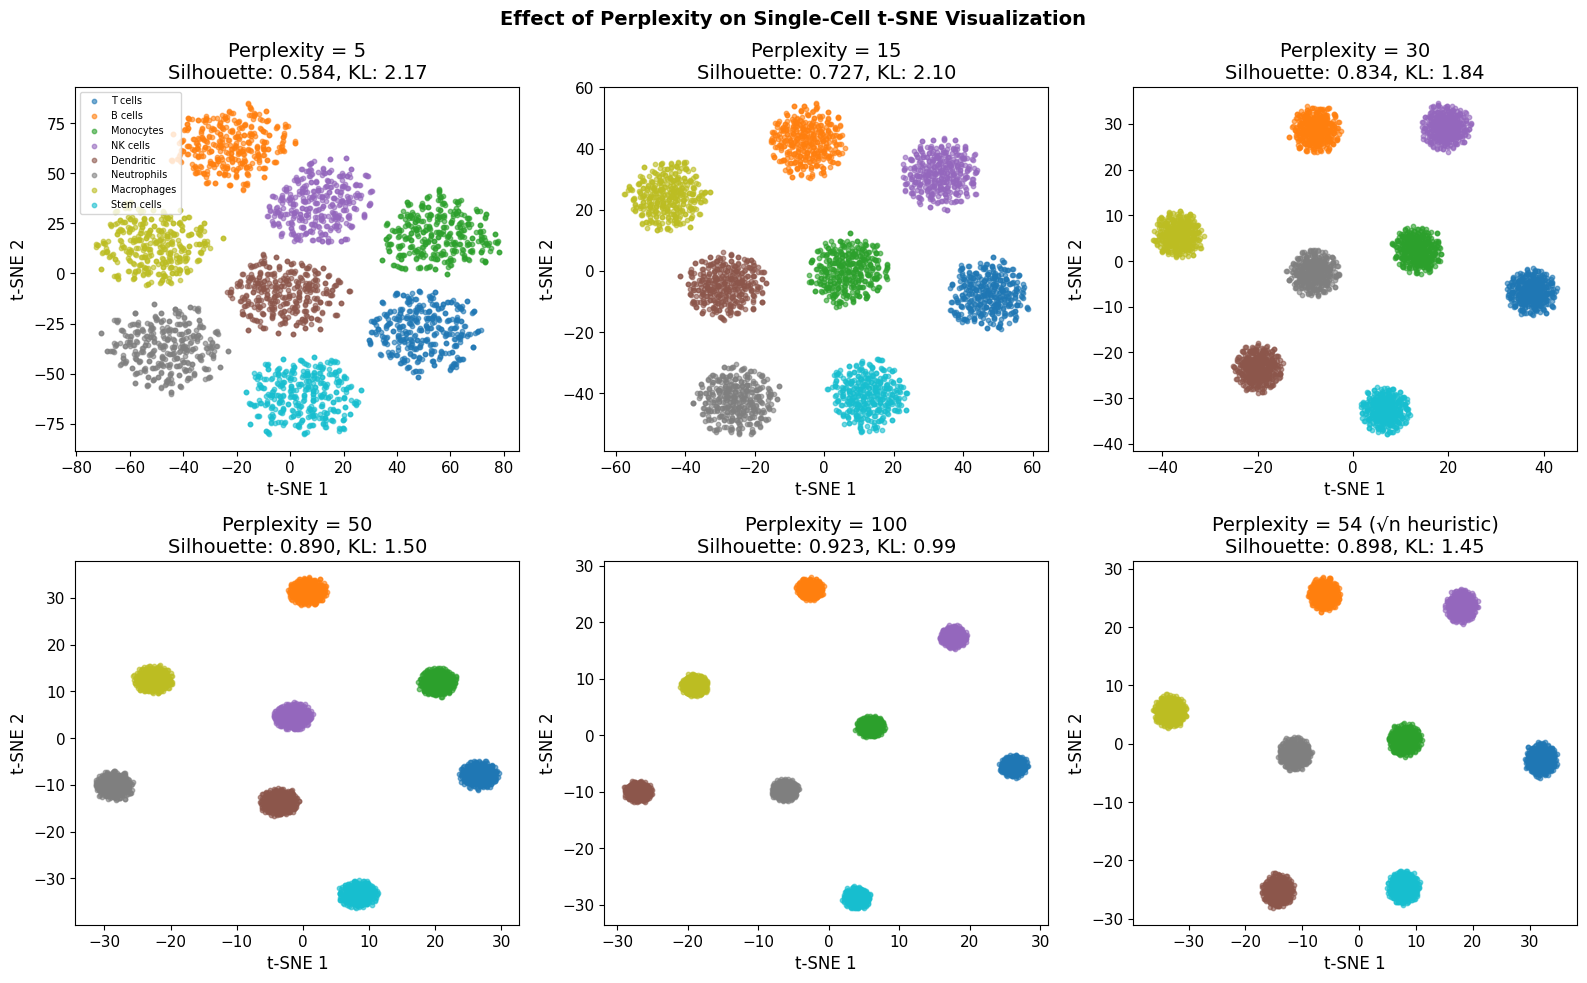

In [7]:
# 4 Effect of Perplexity on Single-Cell Visualization
# Perplexity is the most important hyperparameter for t-SNE

# Common heuristic: perplexity ≈ sqrt(n) or between 30-50
perplexities = [5, 15, 30, 50, 100, int(np.sqrt(n_cells))]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, perp in enumerate(perplexities):
    start_time = time.time()
    tsne = TSNE(n_components=2, perplexity=perp, random_state=RANDOM_STATE,
                max_iter=1000, learning_rate='auto', init='pca')
    X_tsne = tsne.fit_transform(X_pca_50)
    elapsed = time.time() - start_time
    
    # Calculate silhouette score for cluster quality
    sil_score = silhouette_score(X_tsne, cell_types)
    
    for i in range(n_cell_types):
        mask = cell_types == i
        axes[idx].scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                         c=[colors[i]], label=cell_type_names[i] if idx == 0 else None,
                         alpha=0.6, s=10)
    
    # Highlight if this is the sqrt(n) heuristic
    title_suffix = " (√n heuristic)" if perp == int(np.sqrt(n_cells)) else ""
    axes[idx].set_title(f'Perplexity = {perp}{title_suffix}\nSilhouette: {sil_score:.3f}, KL: {tsne.kl_divergence_:.2f}')
    axes[idx].set_xlabel('t-SNE 1')
    axes[idx].set_ylabel('t-SNE 2')

# Add legend to first subplot
axes[0].legend(fontsize=7, loc='best')

plt.suptitle('Effect of Perplexity on Single-Cell t-SNE Visualization', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('scrna_tsne_perplexity.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
print("PERPLEXITY GUIDELINES FOR SINGLE-CELL DATA:")
print("-"*60)
print(f"• Dataset size: {n_cells} cells")
print(f"• √n heuristic: perplexity ≈ {int(np.sqrt(n_cells))}")
print("• Low perplexity (5-15): May fragment cell types into subclusters")
print("• Medium perplexity (30-50): Usually optimal for cell type separation")

PERPLEXITY GUIDELINES FOR SINGLE-CELL DATA:
------------------------------------------------------------
• Dataset size: 3000 cells
• √n heuristic: perplexity ≈ 54
• Low perplexity (5-15): May fragment cell types into subclusters
• Medium perplexity (30-50): Usually optimal for cell type separation


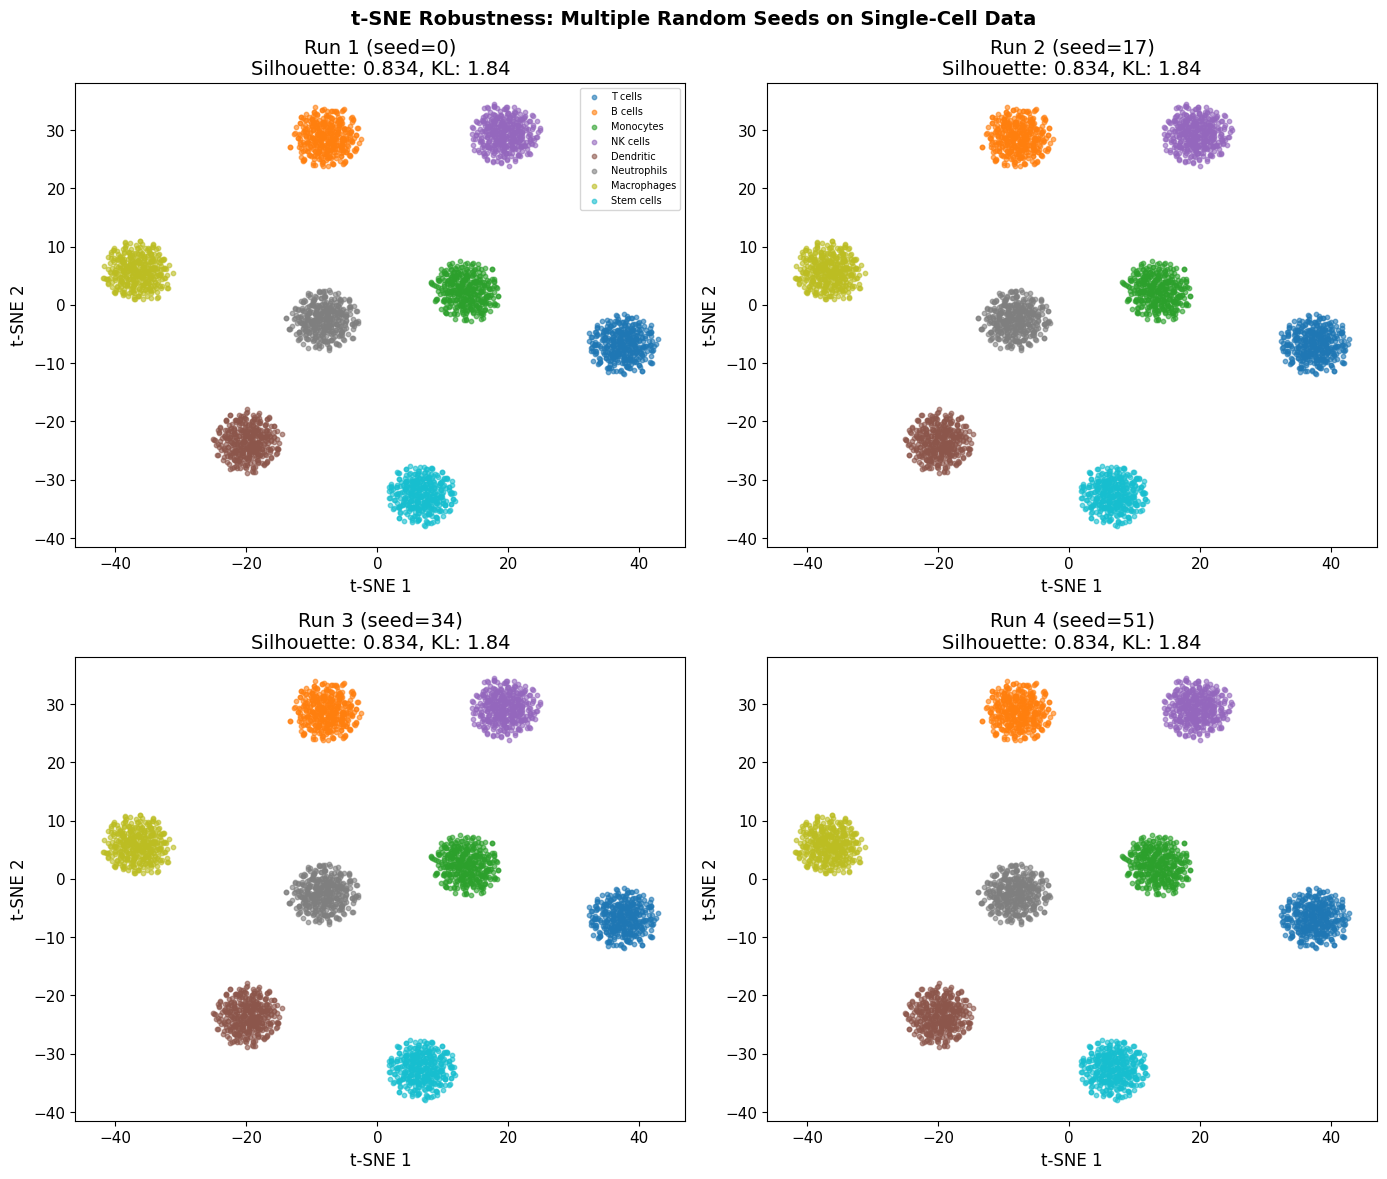

ROBUSTNESS ANALYSIS:
------------------------------------------------------------
Silhouette scores across 4 runs:
  Run 1: 0.8337
  Run 2: 0.8337
  Run 3: 0.8337
  Run 4: 0.8337


In [9]:
# Robustness Check: Multiple Random Seeds
# In real scRNA-seq analysis, researchers run t-SNE multiple times to verify results

n_runs = 4

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

silhouette_scores_runs = []

for idx in range(n_runs):
    # Use different random seeds but same perplexity
    tsne = TSNE(n_components=2, perplexity=30, random_state=idx*17,
                max_iter=1000, learning_rate='auto', init='pca')
    X_tsne = tsne.fit_transform(X_pca_50)
    
    sil_score = silhouette_score(X_tsne, cell_types)
    silhouette_scores_runs.append(sil_score)
    
    for i in range(n_cell_types):
        mask = cell_types == i
        axes[idx].scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                         c=[colors[i]], label=cell_type_names[i] if idx == 0 else None,
                         alpha=0.6, s=10)
    
    axes[idx].set_title(f'Run {idx+1} (seed={idx*17})\nSilhouette: {sil_score:.3f}, KL: {tsne.kl_divergence_:.2f}')
    axes[idx].set_xlabel('t-SNE 1')
    axes[idx].set_ylabel('t-SNE 2')

axes[0].legend(fontsize=7, loc='best')

plt.suptitle('t-SNE Robustness: Multiple Random Seeds on Single-Cell Data', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('scrna_tsne_robustness.png', dpi=150, bbox_inches='tight')
plt.show()

print("ROBUSTNESS ANALYSIS:")
print("-"*60)
print(f"Silhouette scores across {n_runs} runs:")
for i, score in enumerate(silhouette_scores_runs):
    print(f"  Run {i+1}: {score:.4f}")

In [10]:
print(f"\nMean: {np.mean(silhouette_scores_runs):.4f} ± {np.std(silhouette_scores_runs):.4f}")
print("\nKey insight: While exact positions differ, cluster structure is PRESERVED!")
print("This is why t-SNE is acceptable for exploratory single-cell analysis.")
print("="*60)


Mean: 0.8337 ± 0.0000

Key insight: While exact positions differ, cluster structure is PRESERVED!
This is why t-SNE is acceptable for exploratory single-cell analysis.
